In [28]:
# !pip install -r ../requirements.txt

In [1]:
# import sys
# sys.path.append('../')

In [3]:
import io
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from denseclus import DenseClus
from denseclus.numerical import extract_numerical
from denseclus.categorical import extract_categorical

SEED = 42  # random seed to set reproducibility as best we can

sns.set_style("darkgrid")
sns.set_context("notebook")

%matplotlib inline

## Data
Let's start by downloading publicly available *Census Income dataset* available at https://archive.ics.uci.edu/ml/datasets/Adult. In this dataset we have different attributes such as age, work class, education, country, race etc for each person. We also have an indicator of person's income being more than $50K a year. The prediction task is to determine whether a person makes over 50K a year.


### Data Description
Let's talk about the data. At a high level, we can see:

- There are 15 columns and around 32K rows in the training data
- IncomeGroup is the target field

Specifics on the features:

- 8 of the 14 features are categorical and remaining 6 are numeric

Target variable:
- IncomeGroup_>50K: Whether or not annual income was more than 50K

Now lets read this into a Pandas data frame and take a look.

In [4]:
s3 = boto3.client("s3")
region = boto3.session.Session().region_name

## read the data
s3.download_file(
    f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data", "adult.data"
)
df = pd.read_csv("adult.data", header=None)

## set column names
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

df[df["native-country"] == " United-States"]
df.drop(["native-country"], axis=1, inplace=True)

In [5]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
IncomeGroup       object
dtype: object

In [6]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

## K-Means clustering on numerical features
Lets implement K-Means clustering on numerical features and visualize the clusters

In [7]:
numerical_df = extract_numerical(df)
numerical_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.175803,-1.180293,1.164754,3.317526,-0.22121,-0.035570
1,0.891954,-1.089846,1.164754,-0.301425,-0.22121,-2.221546
2,0.102709,0.398784,-0.464368,-0.301425,-0.22121,-0.035570
3,1.064392,0.562579,-1.200303,-0.301425,-0.22121,-0.035570
4,-0.731682,1.340417,1.164754,-0.301425,-0.22121,-0.035570


In [8]:
from sklearn.decomposition import PCA
pca = PCA(2)

numerical_df = pca.fit_transform(numerical_df)
numerical_df.shape

(32561, 2)

In [9]:
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(numerical_df)
 
print(label)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 1 1 ... 0 1 0]


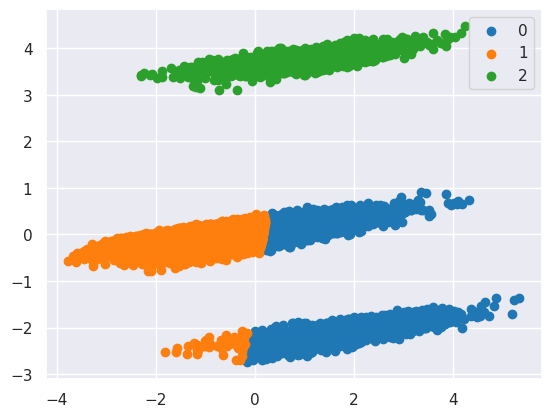

In [10]:
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(numerical_df[label == i , 0] , numerical_df[label == i , 1] , label = i)
plt.legend()
plt.show()

In the above K-Means implementation using traditional dimension reduction PCA, we can see that the clusters formed using only numeric features are of poor quality. It is beacause KMeans and other such clustering algorithms relies on input features to be numeric and assume that the values are shaped spherical in nature.

## Create UMAP embeddings + Fit HdbScan for numerical and categorical features separately

In [11]:
import umap.umap_ as umap
import hdbscan

In [12]:
categorical_df = extract_categorical(df)
numerical_df = extract_numerical(df)

In [13]:
default_umap_params = {
            "categorical": {
                "metric": "hamming",
                "n_neighbors": 30,
                "n_components": 5,
                "min_dist": 0.0,
            },
            "numerical": {
                "metric": "l2",
                "n_neighbors": 30,
                "n_components": 5,
                "min_dist": 0.0,
            }
}

In [14]:
categorical_umap = umap.UMAP(
            random_state=SEED,
            n_jobs=1,
            verbose=False,
            low_memory=True,
            **default_umap_params["categorical"],
        ).fit(categorical_df)


numerical_umap = umap.UMAP(
            random_state=SEED,
            n_jobs=1,
            verbose=False,
            low_memory=True,
            **default_umap_params["numerical"],
        ).fit(numerical_df)

In [15]:
hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

hdb_numerical = hdbscan.HDBSCAN(**hdbscan_params).fit(numerical_umap.embedding_)
hdb_categorical = hdbscan.HDBSCAN(**hdbscan_params).fit(categorical_umap.embedding_)

In [16]:
print(f"DBCV numerical score: {hdb_numerical.relative_validity_}")
print(f"DBCV categorical score: {hdb_categorical.relative_validity_}")

DBCV numerical score: 0.279358228317536
DBCV categorical score: 0.4123077464785735


## DenseClus on all features (numerical + categorical)

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting in groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

#### There are 5 methods by which you can combine embeddings spaces (param: umap_combine_method, default=intersection)

- 'intersection'
- 'union'
- 'contrast'
- 'intersection_union_mapper'
- 'ensemble'

Let's implement each one of the above methods, calculate their **Density Based Clustering Validation (DBCV)** scores and visualize their respective umap embeddings. 

In [17]:
methods = ["intersection", "union", "contrast", "intersection_union_mapper", "ensemble"]

Running method using: intersection
DBCV score 0.684722625616629
Coverage 1.0
Number of clusters: 7
------------------------------
Running method using: union
DBCV score 0.35543533902183644
Coverage 0.8690457909769356
Number of clusters: 131
------------------------------
Running method using: contrast
DBCV score 0.6963244897081085
Coverage 0.9441970455452843
Number of clusters: 23
------------------------------
Running method using: intersection_union_mapper
DBCV score 0.6093614712111133
Coverage 0.994287644728356
Number of clusters: 6
------------------------------
Running method using: ensemble
DBCV numerical score 0.279358228317536
DBCV categorical score 0.4123077464785735
Coverage 0.9997543073001444
Number of clusters: 129
------------------------------


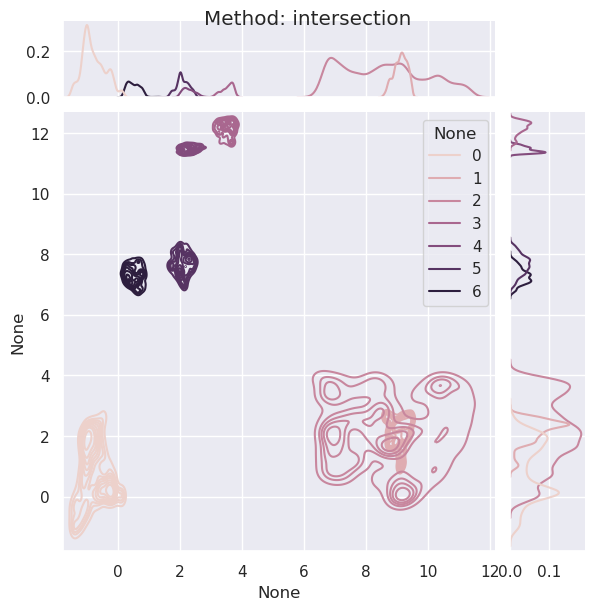

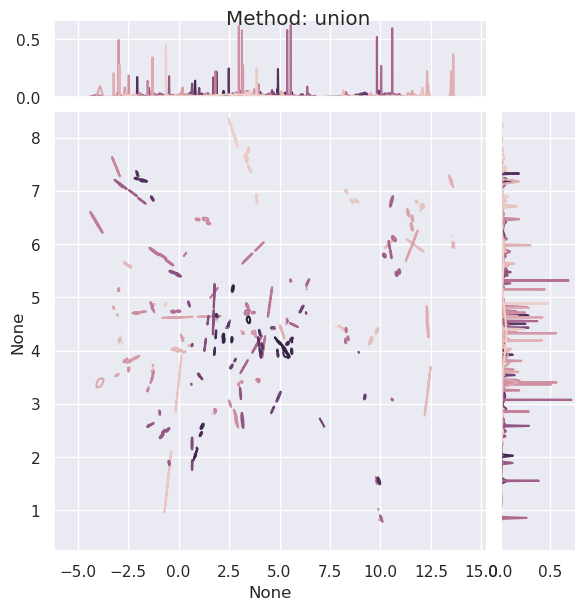

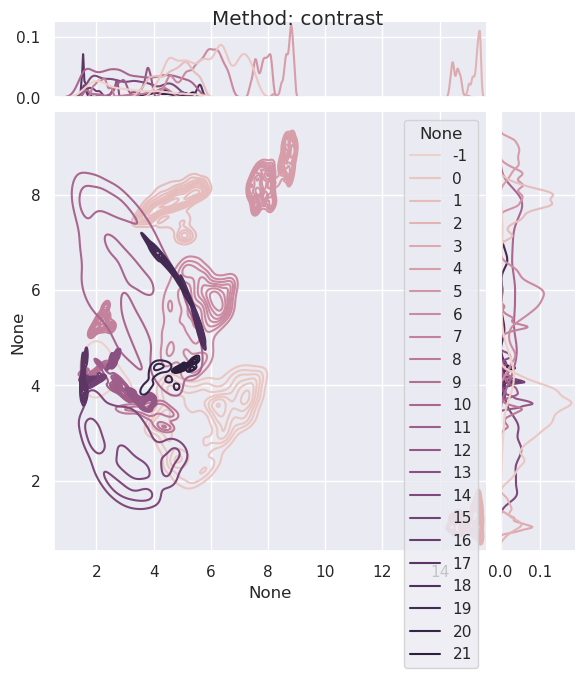

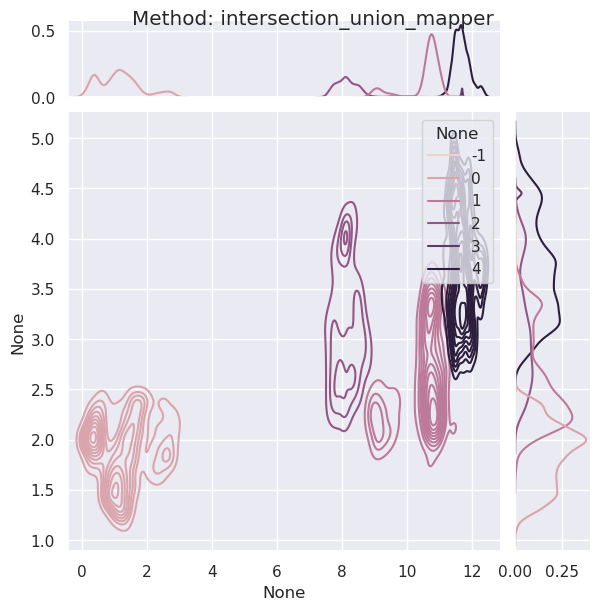

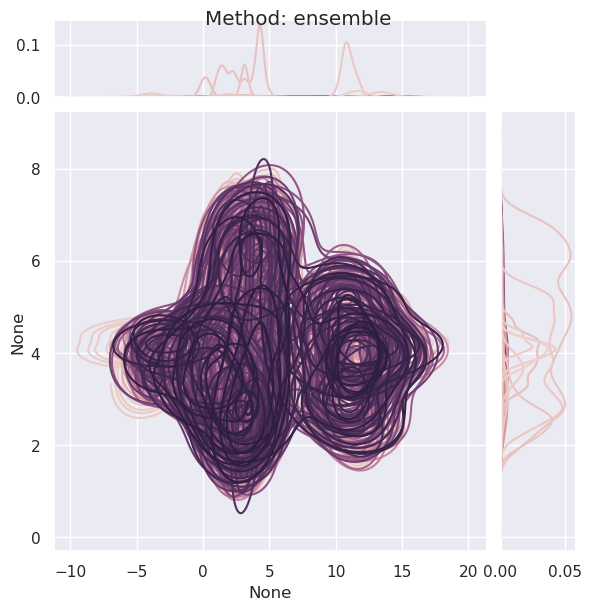

In [20]:
hdbscan_params = {
    "min_cluster_size": 100,
    "min_samples": 15,
    "gen_min_span_tree": True,
    "metric": "euclidean",
}

for method in methods:
    print(f"Running method using: {method}")
    clf = DenseClus(random_state=SEED, umap_combine_method=method, hdbscan_params=hdbscan_params)
    clf.fit(df)
    clusters = clf.evaluate()
    n_clusters=len(np.unique(clusters))
    print(f"Number of clusters: {n_clusters}")
    
    if hasattr(clf, "mapper_"):
        embeddings = clf.mapper_.embedding_
    else:
        embeddings = clf.numerical_umap_.embedding_

    joint_plot = sns.jointplot(x=embeddings[:, 0], y=embeddings[:, -1], hue=clusters, kind="kde", marginal_ticks=True)
    joint_plot.fig.suptitle(f"Method: {method}")
    if n_clusters>50: joint_plot.ax_joint.legend_.remove()

    print("-" * 30)

----------
As a recap the steps that happened are:

1) Numerical features were taken out and then reduced into a *dense* UMAP embedding

2) Categorical features got extracted and learned into a *dense* separate UMAP embedding

3) The two embeddings were then combined with one of the available operations ("intersection", "union", "contrast", "intersection_union_mapper", "ensemble")

4) HDBSCAN uses density-based spatial clustering to hierarchical-fashion to extract clusters from the combined space

All of these features are now attached as usable `DenseClus` object. 

----------
### Metric: Density Based Clustering Validation:

Density Based Clustering Validation or DBCV works for desnity-based clustering algorithms precisely because it takes noise into account and captures the shape property of clusters via densities and not distances (see the [original paper](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf))

As the paper explains, the final result of DBCV is a weighted sum of “Validity Index” values of clusters. This produces a score between -1 to 1, with the larger the value the better clustering solution.

Source: Density-Based Clustering Validation, Moulavi et al. 2014

An in depth discussion is out scope here but please see the original paper for more details.

Note that DBCV does have [drawbacks](https://github.com/scikit-learn-contrib/hdbscan/issues/283). Like all other metrics and techniques DBCV is not immune from the problems of complication and measurement in clustering as noted earlier.

However, outside of having groundtruth labels it provides an objective criteria from which to judge how well-separated density-based technique clusters are.


----------
## Analysis:

Based on the above results for each method: `intersection_union_mapper` seems to be the suitable method for clustering our dataset. As you can see we have 5 distinct islands formed within the slice of the data. Clusters have formed around these densities which is exactly the behavior we expect DenseClus to do.

`Intersection_union_mapper` is a hybrid method that combines the strengths of both 'intersection' and 'union'. It first applies the 'intersection' method to preserve the numerical embeddings, then applies the 'union' method to preserve the categorical embeddings. This method is useful when both numerical and categorical data are important, but one type of data is not necessarily more important than the other.

Let's dive deep into Embedding Results for the intersection_union_mapper method:

In [21]:
clf = DenseClus(random_state=SEED, umap_combine_method="intersection_union_mapper")

clf.fit(df)

In [22]:
clf.evaluate()

DBCV score 0.6093614712111133
Coverage 0.994287644728356


array([0, 0, 3, ..., 4, 4, 4])

## Checking Embedding Results

Verify the embeddings are now densely shaped.

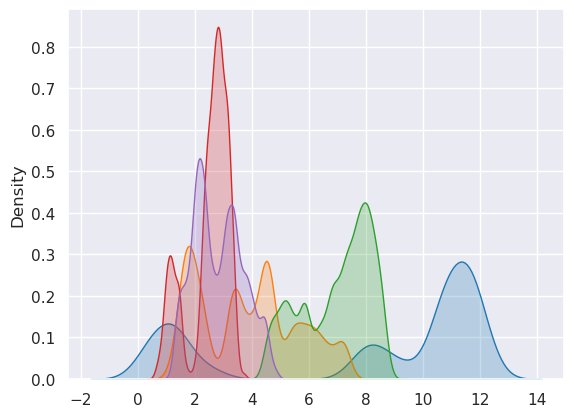

In [23]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [24]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

DBCV score 0.6093614712111133
Coverage 0.994287644728356
   cluster  count
4       -1    186
1        0   9123
2        1   8647
3        2   4109
5        3    109
0        4  10387


Upon examination there are exactly 5 clusters with -1 representing the noise found in the data.

In addition, to simply looking at their spread, another way to evaluate clusters it to visualize them.

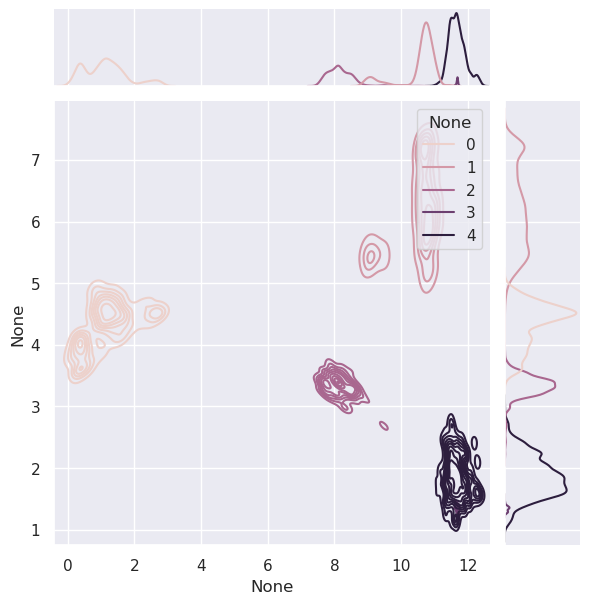

In [25]:
_ = sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde"
)

As you can see above, the clusters formed based on the densities represented in the reduced space.

Specifically, 5 groups got identified by the data.

## Conclusion

I hoped you enjoyed a closer look at DenseClus implementation!!

In this post you looked at 5 different methods for combining umaps, namely "intersection", "union", "contrast", "intersection_union_mapper", "ensemble". We implemented all the 5 methods for the census dataset and compared the clustered results using DBCV score and vislualization of its embeddings. 

For this particular dataset, we learned that "intersection_union_mapper" was able to create 5 distinct islands around the densities which is exactly the behavior we expect DenseClus to do. 

Feel free to experiment with the umap_combine_method and the hdbscan parameters to see which works best for your dataset. 